In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import metrics
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import Callback
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing

In [ ]:
!unzip /content/drive/MyDrive/ifood-2019-fgvc6.zip

Streaming output truncated to the last 5000 lines.
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_007118.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_007118.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_000306.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_000306.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_000060.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_000060.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_003031.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_003031.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_009643.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_009643.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_003805.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_003805.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_003581.jpg  

In [2]:
num_classes = 251
width, height = 224, 224
train_dir = '/Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set'
val_dir = '/Users/nieves/Downloads/ifood-2019-fgvc6/organized_val_set'
test_dir = '/Users/nieves/Downloads/ifood-2019-fgvc6/test_set'
batch_size = 32

In [3]:
csv_path = '/Users/nieves/Downloads/FoodX251/annot/train_incorrect.csv'

incorrect_images_df = pd.read_csv(csv_path, header=None)
incorrect_images = incorrect_images_df[0].tolist() 

for root, dirs, files in os.walk(train_dir):  # Traverse through all class subdirectories
    for img_file in incorrect_images:
        img_path = os.path.join(root, img_file)
        if os.path.exists(img_path):
            os.remove(img_path)
            print(f"Removed {img_file} from {root}")

Removed train_011484.jpg from /Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set/135
Removed train_079854.jpg from /Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set/61
Removed train_079981.jpg from /Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set/61
Removed train_079997.jpg from /Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set/61
Removed train_080281.jpg from /Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set/61
Removed train_080257.jpg from /Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set/61
Removed train_080261.jpg from /Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set/61
Removed train_080249.jpg from /Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set/61
Removed train_080133.jpg from /Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set/61
Removed train_080019.jpg from /Users/nieves/Downloads/ifood-2019-fgvc6/organized_train_set/61
Removed train_080012.jpg from /Users/nieves/Downloads/ifood

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    validation_split=0.3,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [5]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical',
)

val_set = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(width, height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
)

Found 114154 images belonging to 251 classes.
Found 11994 images belonging to 251 classes.


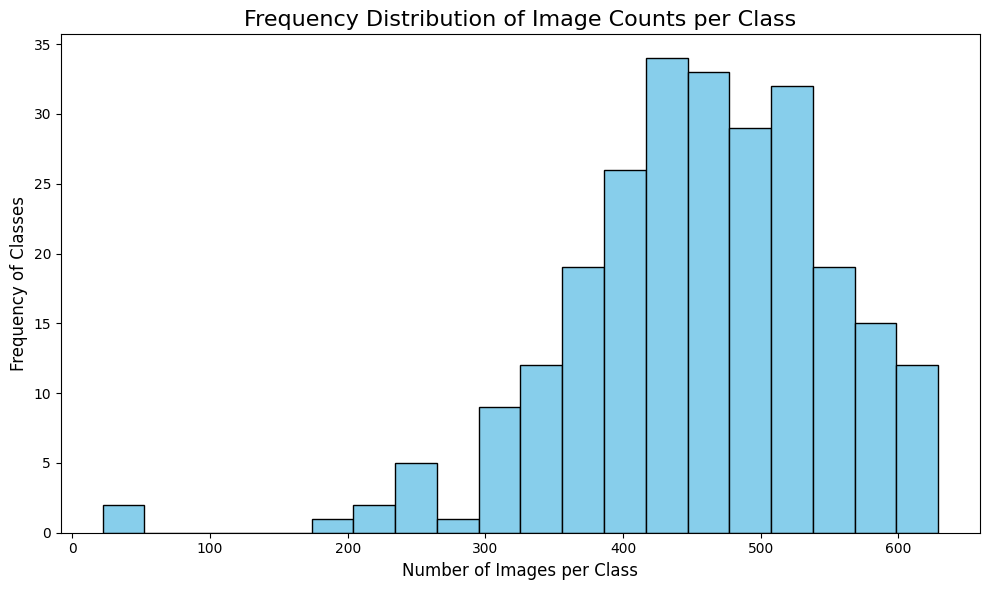

In [ ]:
# Get a list of all class directories
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Count the number of images in each class directory
class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in class_dirs]

# Plot the frequency of image counts using a histogram
plt.figure(figsize=(10, 6))
plt.hist(class_counts, bins=20, color='skyblue', edgecolor='black')

plt.title('Frequency Distribution of Image Counts per Class', fontsize=16)
plt.xlabel('Number of Images per Class', fontsize=12)
plt.ylabel('Frequency of Classes', fontsize=12)

plt.tight_layout()

# Display the frequency chart
plt.show()



In [6]:
from sklearn.utils import class_weight

class_labels = train_set.classes  # Labels for each image in the training set

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(class_labels),
                                                  y=class_labels)

# Keras requires dict format
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.7323620173091852, 1: 0.8564911727853183, 2: 1.4212400398406375, 3: 1.060132430650359, 4: 0.915084130279686, 5: 0.8406595429741294, 6: 1.7492185105730922, 7: 0.9951790213326126, 8: 0.963552569383483, 9: 0.9514577672573306, 10: 0.9281567607122531, 11: 1.1174368863611892, 12: 1.3455527004408403, 13: 0.7950993229877692, 14: 1.062609375581785, 15: 0.8900133321898317, 16: 0.8746092552865461, 17: 1.0479189233848019, 18: 0.9615154603573023, 19: 0.79095097869392, 20: 20.672582397682, 21: 0.7395070126000065, 22: 0.8092469977740284, 23: 0.7443483023715286, 24: 0.7517302690066181, 25: 0.8150480515215125, 26: 1.252883781677697, 27: 0.9865440623622647, 28: 0.8662796433314361, 29: 0.8485015163227686, 30: 1.0701101476447152, 31: 0.9059697465119602, 32: 1.075169770092208, 33: 1.2325116876666775, 34: 0.804950111060184, 35: 1.0958959343349493, 36: 0.8746092552865461, 37: 1.1572437983435215, 38: 0.9844086856039047, 39: 1.075169770092208, 40: 1.1661456737153948, 41: 1.0407249719656841,

# Model Callbacks

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Kaggle/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Get the current timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Callbacks
Callbacks = [
    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, f'Created_Dense_Best_{timestamp}.keras'),
                    save_best_only=True,
                    monitor='val_loss',
                    mode='min',
                    verbose=1),  # Save the best model based on validation loss
    EarlyStopping(monitor='val_loss',
                  patience=10,  # Stop training after 10 epochs without improvement
                  mode='min',
                  verbose=1,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.2,  # Reduce learning rate by 20%
                      patience=3,  # Reduce if no improvement after 3 epochs
                      mode='min',
                      verbose=1),
]

In [ ]:
class SaveHistory(Callback):

    def __init__(self, save_path):

        super(SaveHistory, self).__init__()

        self.save_path = save_path

        # Load history if exists
        if os.path.exists(self.save_path):

            with open(self.save_path, 'rb') as f:
                self.history = pickle.load(f)

        else:
            self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': [], 'precision': [], 'val_precision': [], 'recall': [], 'val_recall': []}

    def on_epoch_end(self, epoch, logs=None):
        # Append new logs to the existing history
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['precision'].append(logs.get('precision'))
        self.history['val_precision'].append(logs.get('val_precision'))
        self.history['recall'].append(logs.get('recall'))
        self.history['val_recall'].append(logs.get('val_recall'))

        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(self.save_path), exist_ok=True)

        # Save history to a file
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

        print(f"Epoch {epoch+1} history saved to {self.save_path}")

# Create a unique filename with a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
history_save_path = f'/content/drive/MyDrive/Kaggle/created_Dense_train_{timestamp}.pkl'

# Create the callback
history_callback = SaveHistory(save_path=history_save_path)


# Creating DenseNet and Testing

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def dense_block(x, growth_rate, num_layers):
    for i in range(num_layers):
        output = layers.BatchNormalization()(x)
        output = layers.ReLU()(output)
        output = layers.Conv2D(growth_rate, (3, 3), padding='same')(output)

        # Concatenate input with the new output
        x = layers.concatenate([x, output])
    return x

def transition_layer(x, reduction):
    filters = int(x.shape[-1] * reduction)  # Reduce number of filters
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.AveragePooling2D((2, 2), strides=2)(x)  # Downsample
    return x

def build_densenet(input_shape=(224, 224, 3), num_classes=251, growth_rate=32):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)


    x = dense_block(x, growth_rate, 6)
    x = transition_layer(x, 0.5)

    x = dense_block(x, growth_rate, 12)
    x = transition_layer(x, 0.5)

    x = dense_block(x, growth_rate, 24)
    x = transition_layer(x, 0.5)

    x = dense_block(x, growth_rate, 16)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model


model = build_densenet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 32)     │         18,464 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56, 56, 96)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 96)     │            384 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 96)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 32)     │         27,680 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 56, 56, 128)    │              0 │ concatenate[0][0],     │
│ (Concatenate)             │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 128)    │            512 │ concatenate_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 56, 56, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 32)     │         36,896 │ re_lu_3[0][0]          │
├──────────────────────

 Total params: 10,168,891 (38.79 MB)

 Trainable params: 10,102,139 (38.54 MB)

 Non-trainable params: 66,752 (260.75 KB)

In [ ]:
'''
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

history = model.fit(train_set,
                      validation_data=val_set,
                      epochs=20,
                      verbose=1,
                      class_weight=class_weights_dict,
                      callbacks=[Callbacks, history_callback])

'''

loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Kaggle/Created_Dense_Best.keras')

history = loaded_model.fit(train_set,
                      validation_data=val_set,
                      epochs=30,
                      verbose=1,
                      class_weight=class_weights_dict,
                      callbacks=[Callbacks, history_callback])



Epoch 1/30
3568/3568 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.5044 - loss: 2.0184 - precision: 0.7499 - recall: 0.3532
Epoch 1: val_loss improved from inf to 2.26074, saving model to /content/drive/MyDrive/Kaggle/Created_Dense_Best_20241108-053135.keras
Epoch 1 history saved to /content/drive/MyDrive/Kaggle/created_Dense_train_20241108_053137.pkl
3568/3568 ━━━━━━━━━━━━━━━━━━━━ 1423s 377ms/step - accuracy: 0.5044 - loss: 2.0185 - precision: 0.7499 - recall: 0.3532 - val_accuracy: 0.4682 - val_loss: 2.2607 - val_precision: 0.6811 - val_recall: 0.3395 - learning_rate: 0.0010
Epoch 2/30
3568/3568 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5102 - loss: 1.9745 - precision: 0.7456 - recall: 0.3625
Epoch 2: val_loss did not improve from 2.26074
Epoch 2 history saved to /content/drive/MyDrive/Kaggle/created_Dense_train_20241108_053137.pkl
3568/3568 ━━━━━━━━━━━━━━━━━━━━ 1265s 354ms/step - accuracy: 0.5102 - loss: 1.9745 - precision: 0.7456 - recall: 0.3625 - val_accuracy: 0.3974 - 

# Evaluating Model Results

In [9]:
'''
loaded_model = tf.keras.models.load_model('/Users/nieves/Downloads/Created_Dense_Best_20241108-053135.keras')
y_true = val_set.classes
prediction = loaded_model.predict(val_set)
y_pred = np.argmax(prediction, axis=1)
'''
label_map = {}
with open('/Users/nieves/Downloads/ifood-2019-fgvc6/class_list.txt', 'r') as f:
    for line in f:
        numerical_label, actual_label = line.strip().split()
        label_map[int(numerical_label)] = actual_label

y_true_mapped = [label_map[label] for label in y_true]
y_pred_mapped = [label_map[label] for label in y_pred]


print("Sample of y_true:", y_true_mapped[:10])
print("Sample of y_pred:", y_pred_mapped[:10])

# Generate the classification report
report = classification_report(y_true_mapped, y_pred_mapped, zero_division=1)
print(report)


Sample of y_true: ['macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron']
Sample of y_pred: ['guacamole', 'macaron', 'macaron', 'macaron', 'savarin', 'macaron', 'macaron', 'syllabub', 'toad_in_the_hole', 'macaron']
                               precision    recall  f1-score   support

                        adobo       0.24      0.30      0.27        40
                ambrosia_food       0.46      0.50      0.48        42
                    apple_pie       0.91      0.66      0.76        44
               apple_turnover       0.40      0.33      0.36        43
                   applesauce       0.32      0.39      0.35        33
              applesauce_cake       0.40      0.39      0.39        57
                baby_back_rib       0.30      0.40      0.34        35
               bacon_and_eggs       0.67      0.70      0.68        57
bacon_lettuce_tomato_sandwich       0.68      0.87      0.76        62
                 ba

In [ ]:
result = loaded_model.evaluate(val_set)
print("\nTest Loss:", result[0])
print("Test Accuracy:", result[1])
print("Test Precision:", result[2])
print("Test Recall:", result[3])

375/375 ━━━━━━━━━━━━━━━━━━━━ 52s 95ms/step - accuracy: 0.5555 - loss: 2.0120 - precision: 0.6928 - recall: 0.4821

Test Loss: 1.9996720552444458
Test Accuracy: 0.5517758727073669
Test Precision: 0.6847967505455017
Test Recall: 0.48182424902915955


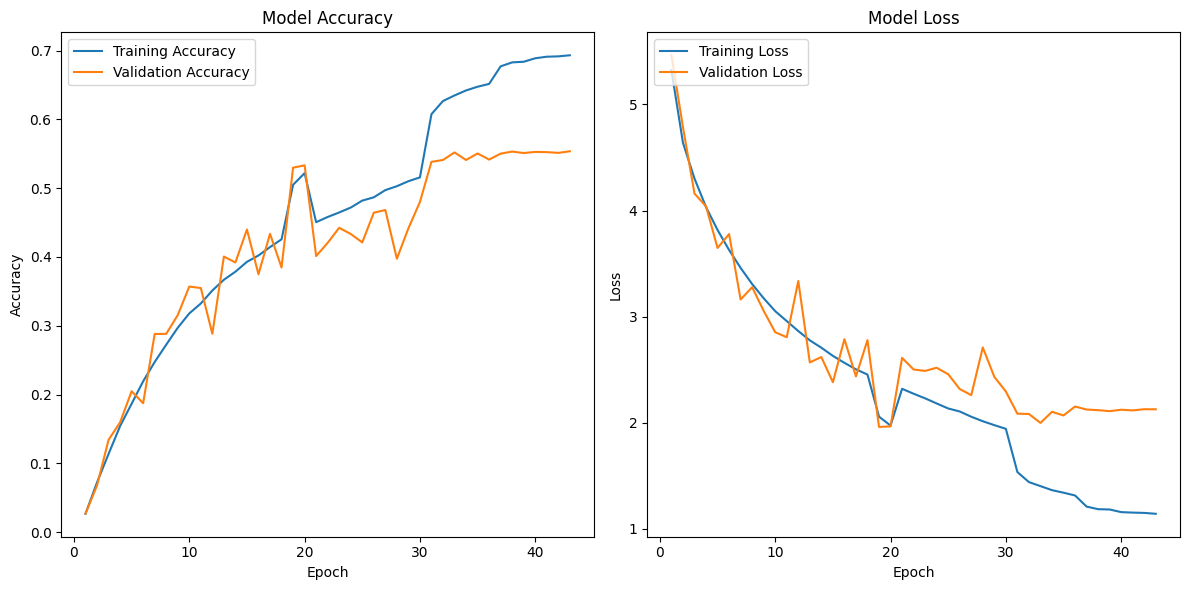

In [ ]:
# Load the history from all sessions
with open('/content/drive/MyDrive/Kaggle/created_Dense_train_history_20241104_183214 (1).pkl', 'rb') as file:
    history1 = pickle.load(file)

with open('/content/drive/MyDrive/Kaggle/created_Dense_train_history_20241106_103428.pkl', 'rb') as file:
    history2 = pickle.load(file)

with open('/content/drive/MyDrive/Kaggle/created_Dense_train_20241108_053137.pkl', 'rb') as file:
    history3 = pickle.load(file)

combined_history = {}
for key in history1.keys():
    combined_history[key] = history1[key] + history2[key] + history3[key]

epochs = np.arange(1, len(combined_history['loss']) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, combined_history['accuracy'], label='Training Accuracy')
plt.plot(epochs, combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, combined_history['loss'], label='Training Loss')
plt.plot(epochs, combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [78]:
report = classification_report(y_true_mapped, y_pred_mapped, zero_division=1, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.sort_values(by='f1-score', ascending=False).head(10)



,precision,recall,f1-score,support
bruschetta,0.900000,0.775862,0.833333,58.0
oyster,0.851852,0.793103,0.821429,58.0
rock_cake,0.787234,0.840909,0.813187,44.0
bread_pudding,0.767857,0.860000,0.811321,50.0
filet_mignon,0.916667,0.721311,0.807339,61.0
beignet,0.827586,0.786885,0.806723,61.0
mussel,0.853659,0.760870,0.804598,46.0
coq_au_vin,0.833333,0.769231,0.800000,65.0
dumpling,0.880952,0.725490,0.795699,51.0
tuna_tartare,0.803571,0.762712,0.782609,59.0


In [79]:
df_report.sort_values(by='f1-score', ascending=True).head(10)

,precision,recall,f1-score,support
churro,0.050000,0.090909,0.064516,11.0
farfalle,0.192308,0.100000,0.131579,50.0
coconut_cake,0.140351,0.222222,0.172043,36.0
sukiyaki,0.833333,0.102041,0.181818,49.0
falafel,0.205128,0.190476,0.197531,42.0
pancake,0.228571,0.190476,0.207792,42.0
flan,0.280000,0.166667,0.208955,42.0
pirogi,0.186441,0.275000,0.222222,40.0
strawberry_shortcake,0.209302,0.243243,0.225000,37.0
schnitzel,0.206897,0.260870,0.230769,23.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


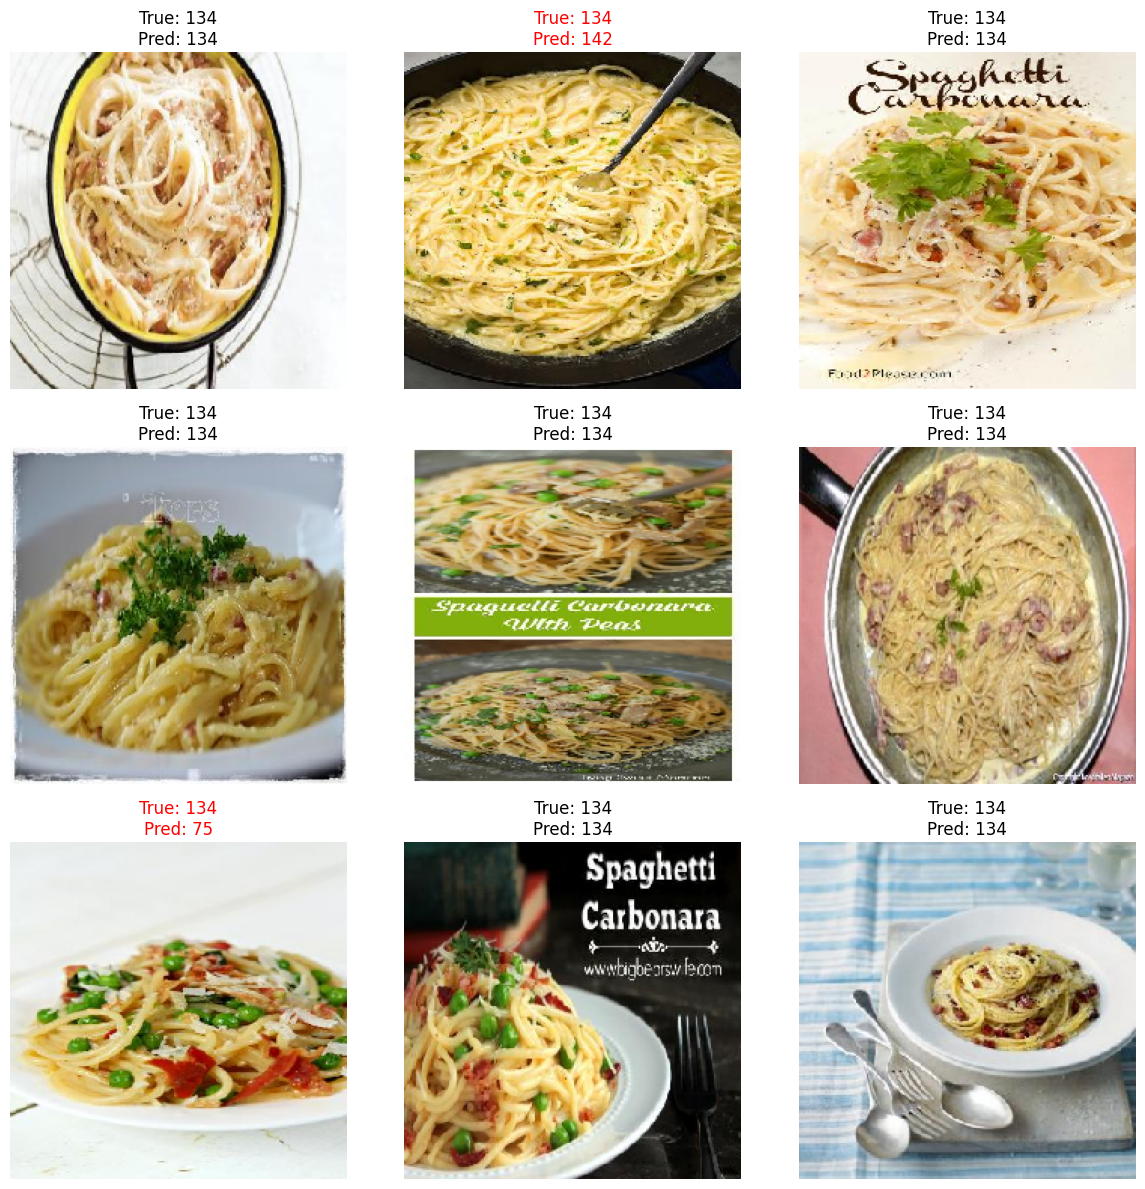

In [ ]:
class_labels = list(val_set.class_indices.keys())
val_set.reset()
for i in range(60):
    x_val, y_val_true = next(val_set)

y_val_pred = loaded_model.predict(x_val)

y_val_true_indices = np.argmax(y_val_true, axis=1)
y_val_pred_indices = np.argmax(y_val_pred, axis=1)

plt.figure(figsize=(12, 12))
for i in range(9):  # Plot 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_val[i])
    true_label = class_labels[y_val_true_indices[i]]
    pred_label = class_labels[y_val_pred_indices[i]]
    color = "black" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
class_list_path = '/Users/nieves/Downloads/ifood-2019-fgvc6/class_list.txt'

# Read the class list from the file
class_list = {}
with open(class_list_path, 'r') as file:
    for line in file:
        class_number, food_name = line.strip().split(maxsplit=1)
        class_list[int(class_number)] = food_name

# Generate the output as a list of dictionaries
data = []
for class_number, food_name in class_list.items():
    class_path = os.path.join(train_dir, str(class_number))
    if os.path.exists(class_path):
        num_images = len(os.listdir(class_path))
        data.append({"Class Number": class_number, "Food Name": food_name, "Num Images": num_images})

# Convert the list to a pandas DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by number of images in descending order
sorted_df = df.sort_values(by="Num Images", ascending=False)

# Display the top 20 classes without the index
top_20 = sorted_df.head(20)
print(top_20.to_string(index=False))


 Class Number           Food Name  Num Images
          155              churro         629
          218              huitre         626
            0             macaron         621
          117           crab_food         615
          219        chiffon_cake         613
          119         coffee_cake         611
           90             compote         608
          227          crumb_cake         606
           12            couscous         605
           38                orzo         605
          140           enchilada         604
           82          beet_salad         602
          141             ceviche         598
           98             lasagna         593
           57             gnocchi         593
           79 macaroni_and_cheese         592
          169       bread_pudding         586
          197           clam_food         586
            8            dumpling         585
          198             burrito         585


In [12]:
# Display the top 20 classes without the index
top_20 = sorted_df.tail(20)
print(top_20.to_string(index=False))

 Class Number         Food Name  Num Images
           10             knish         320
          216 lobster_thermidor         318
          209     welsh_rarebit         317
          183             pizza         316
          247       eccles_cake         311
          174           hot_dog         310
          153      french_fries         307
          248   moo_goo_gai_pan         307
          245        matzo_ball         300
           83     steak_tartare         289
          164         hamburger         261
          103       sauerbraten         260
          149        blancmange         253
          213  veal_cordon_bleu         235
          238           rugulah         235
          159          scrapple         231
           99          lutefisk         212
          239         rock_cake         179
          162       marble_cake          33
          116               poi          22


                precision    recall  f1-score  support
adobo            0.240000  0.300000  0.266667     40.0
ambrosia_food    0.456522  0.500000  0.477273     42.0
apple_pie        0.906250  0.659091  0.763158     44.0
apple_turnover   0.400000  0.325581  0.358974     43.0
applesauce       0.317073  0.393939  0.351351     33.0
...                   ...       ...       ...      ...
vol_au_vent      0.574468  0.551020  0.562500     49.0
waffle           0.518519  0.500000  0.509091     56.0
welsh_rarebit    0.609756  0.543478  0.574713     46.0
wonton           0.678571  0.413043  0.513514     46.0
ziti             0.500000  0.439024  0.467532     41.0

[251 rows x 4 columns]
     Class Number     Food Name  precision    recall  f1-score  support  \
53            155        churro   0.050000  0.090909  0.064516     11.0   
124           218        huitre   0.585366  0.444444  0.505263     54.0   
140             0       macaron   0.878049  0.654545  0.750000     55.0   
67            11

/var/folders/lx/j_srlrtx02jgkgkfshyz8nr80000gn/T/ipykernel_23745/117719191.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Num Images', y='f1-score', data=class_analysis_sorted, palette='viridis', ci=None)
/var/folders/lx/j_srlrtx02jgkgkfshyz8nr80000gn/T/ipykernel_23745/117719191.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Num Images', y='f1-score', data=class_analysis_sorted, palette='viridis', ci=None)


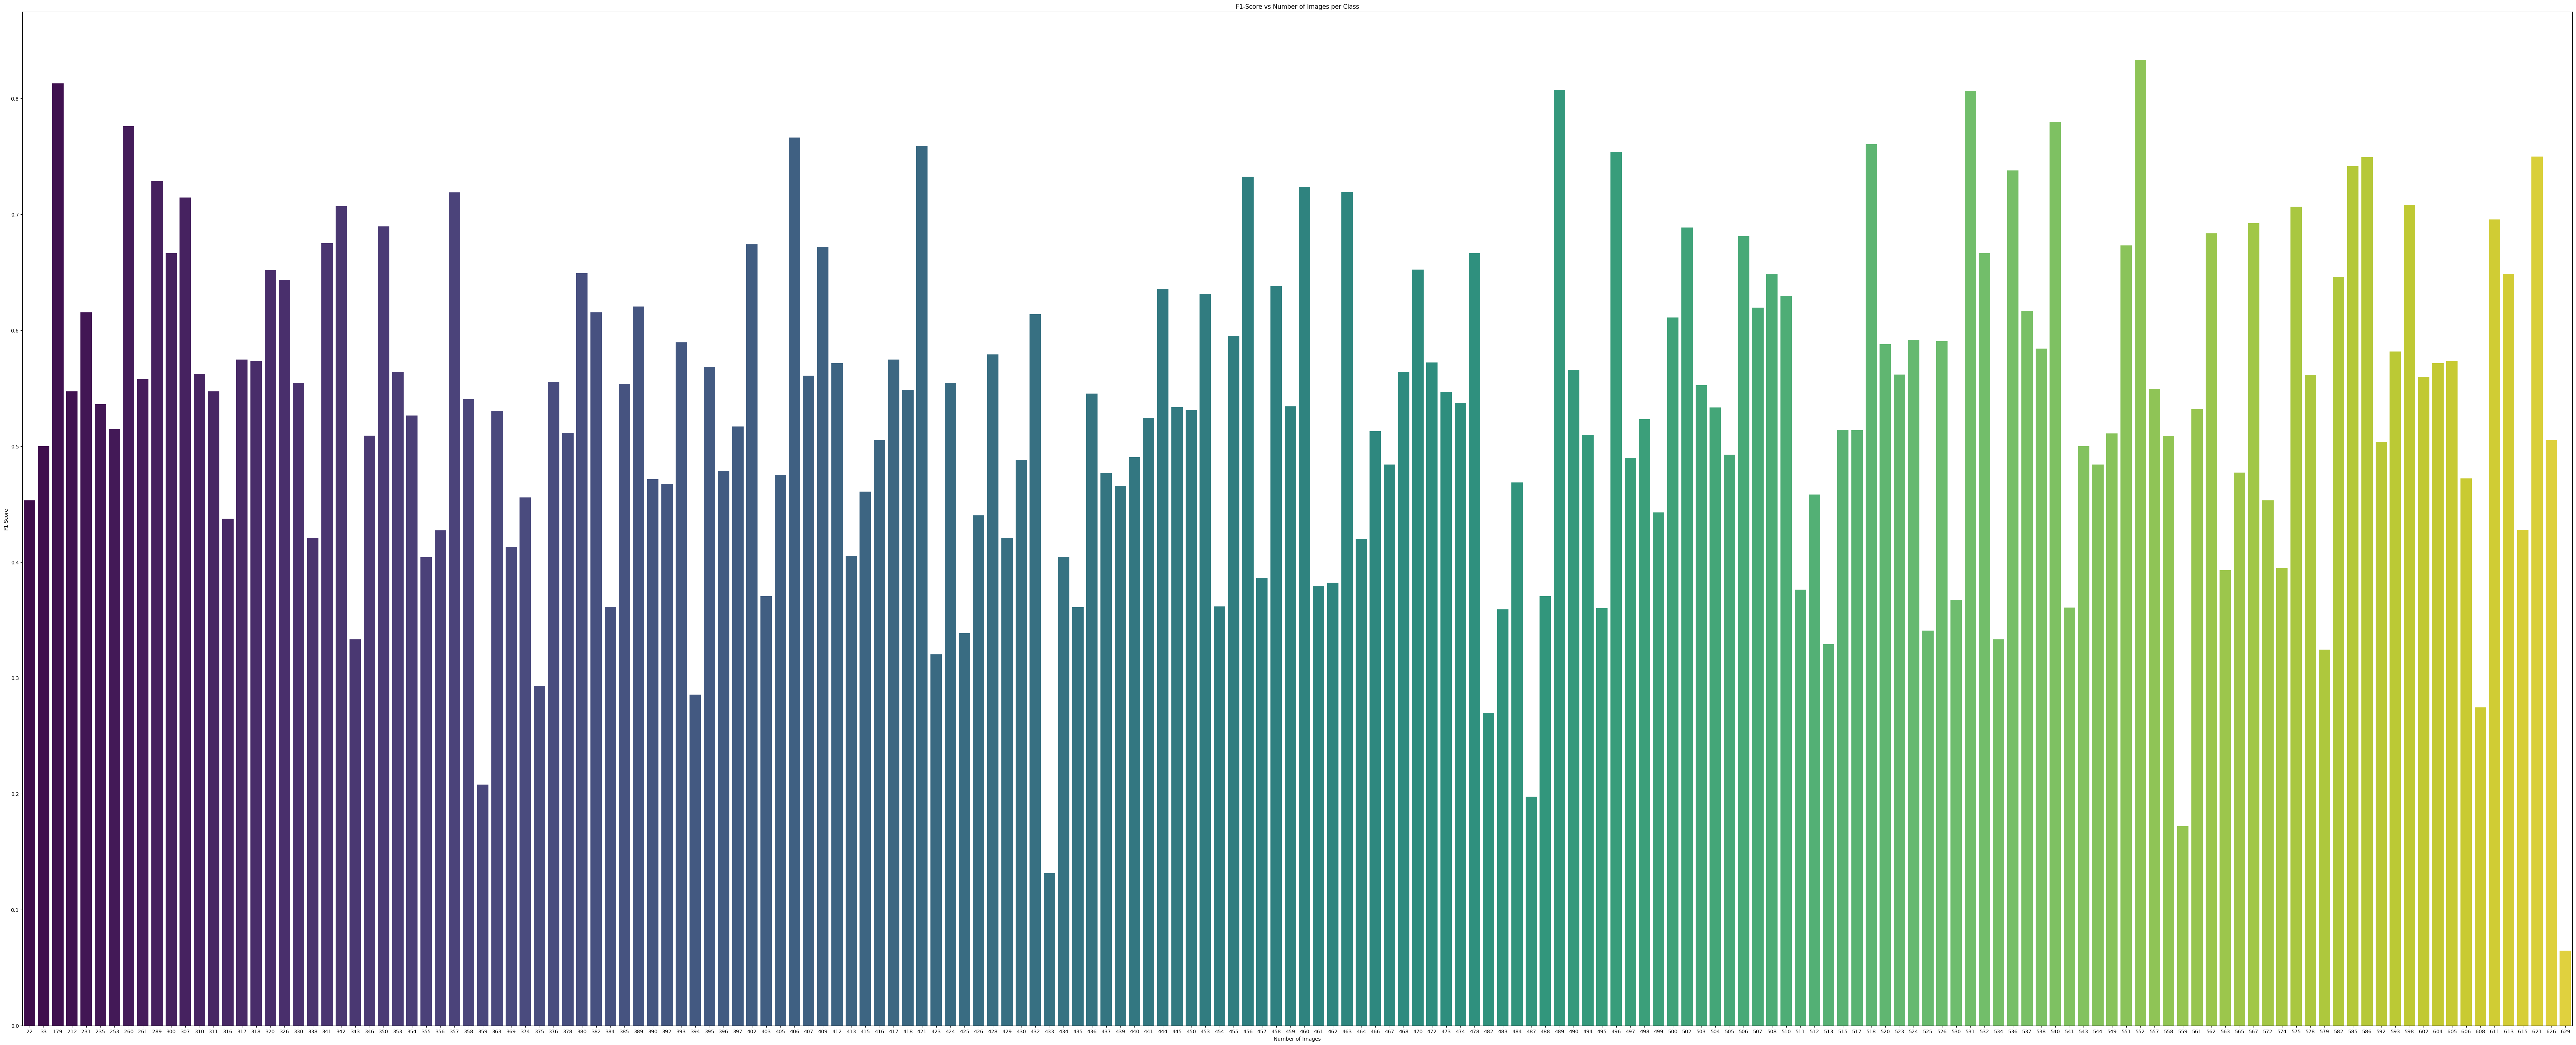

In [77]:
class_list = label_map.values()
metrics_df = df_report
metrics_df = df_report.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
print(metrics_df)
metrics_df.insert(0, "Food Name", metrics_df.index)
metrics_df.reset_index(drop=True, inplace=True)

reverse_label_map = {v: k for k, v in label_map.items()}

# Create the new column "Class Number" using the reversed dictionary
metrics_df['Class Number'] = metrics_df['Food Name'].map(reverse_label_map)

metrics_df.insert(0, "Class Number", metrics_df.pop("Class Number"))

class_analysis = metrics_df.merge(df, on=['Food Name', 'Class Number'], how='left')

# Sort by F1-score and display
class_analysis_sorted = class_analysis.sort_values(by='Num Images', ascending=False)
print(class_analysis_sorted)

# Plot F1-score vs. Number of Images
plt.figure(figsize=(90, 36))
sns.barplot(x='Num Images', y='f1-score', data=class_analysis_sorted, palette='viridis', ci=None)
plt.title('F1-Score vs Number of Images per Class')
plt.xlabel('Number of Images')
plt.ylabel('F1-Score')
plt.show()


In [76]:
class_labels = list(val_set.class_indices.keys())

y_val_true_indices = []
y_val_pred_indices = []
x_val_all = []

val_set.reset()

for x_val, y_val_true in val_set:
    y_val_pred = loaded_model.predict(x_val)
    
    # Store true and predicted labels
    y_val_true_indices.extend(np.argmax(y_val_true, axis=1))  # True labels
    y_val_pred_indices.extend(np.argmax(y_val_pred, axis=1))  # Predicted labels
    x_val_all.extend(x_val)  # Store images for later visualization
    if len(x_val_all) >= len(val_set) * val_set.batch_size:
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

KeyboardInterrupt: 

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val_true_indices, y_val_pred_indices)
'''
plt.figure(figsize=(120, 100))
sns.heatmap(conf_matrix, xticklabels=class_labels, yticklabels=class_labels, cmap='coolwarm', annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
'''
# Identify common misclassifications
misclassified_pairs = []
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if i != j and conf_matrix[i, j] > 0:  # Misclassification
            misclassified_pairs.append((i, j, conf_matrix[i, j]))  # Store indices and count

# Sort by frequency of misclassification
misclassified_pairs = sorted(misclassified_pairs, key=lambda x: x[2], reverse=True)

misclassified_pairs = misclassified_pairs[:10]

# Display the most common misclassifications
print("Most common misclassifications:")
for true_class_idx, pred_class_idx, count in misclassified_pairs:
    print(f"{class_labels[true_class_idx]} misclassified as {class_labels[pred_class_idx]}: {count} times")

# Visualize common misclassifications
plt.figure(figsize=(12, 12))

# Show 9 most common misclassifications
for idx, (true_class_idx, pred_class_idx, count) in enumerate(misclassified_pairs[:9]):
    # Find misclassified images
    misclassified_indices = [i for i in range(len(y_val_true_indices)) 
                             if y_val_true_indices[i] == true_class_idx and y_val_pred_indices[i] == pred_class_idx]
    
    if len(misclassified_indices) > 0:
        img_idx = misclassified_indices[0]  
        plt.subplot(3, 3, idx + 1)
        plt.imshow(x_val_all[img_idx])
        true_label = class_labels[true_class_idx]
        pred_label = class_labels[pred_class_idx]
        color = "red" 
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [84]:
class_analysis_sorted.sort_values(by='f1-score', ascending=False).head(10)

,Class Number,Food Name,precision,recall,f1-score,support,Num Images
27,150,bruschetta,0.900000,0.775862,0.833333,58.0,552
157,195,oyster,0.851852,0.793103,0.821429,58.0,445
189,239,rock_cake,0.787234,0.840909,0.813187,44.0,179
25,169,bread_pudding,0.767857,0.860000,0.811321,50.0,586
91,163,filet_mignon,0.916667,0.721311,0.807339,61.0,489
19,1,beignet,0.827586,0.786885,0.806723,61.0,531
151,191,mussel,0.853659,0.760870,0.804598,46.0,496
62,77,coq_au_vin,0.833333,0.769231,0.800000,65.0,460
80,8,dumpling,0.880952,0.725490,0.795699,51.0,585
241,166,tuna_tartare,0.803571,0.762712,0.782609,59.0,421
